In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn import  cross_validation, tree
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder



C:\Anaconda\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Anaconda\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


###  Upload file


In [38]:
File = r'C:\python\Off.csv'

In [39]:
Off = pd.read_csv(File, sep=';', encoding='cp1251')
Off.head()

,USER_ID,PHONE,DATE_BEGIN,DATE_END,COD,NAME
0,143779,NaN,01.03.1997,21.07.2015,20155,ПВ Пользование абонентской радиоточкой
1,143779,NaN,01.10.2014,15.07.2015,1470,ГТС Тональный набор
2,143779,NaN,01.10.2014,15.07.2015,1469,ГТС Уведомление о поступлении нового вызова
3,143780,3842524316,01.10.2013,21.01.2016,203403,ГТС Пред.в пост.польз.абон.линии с инд.схемой ...
4,143780,NaN,01.10.2014,21.01.2016,1469,ГТС Уведомление о поступлении нового вызова


### Selecting Services into separate table

In [4]:
#Search for the most commomly used services
drop = Off.drop_duplicates(['COD'], keep='last')
name = drop[['COD','NAME']]
name= name.reset_index(level=None)
del name['index']
name = name.set_index(['COD'])
name.head()

,NAME
COD,
97728,*Добровольная блокировка порта XDSL
40570,ГТС Пред.впольз.аб.лин.с спар.сх.с аб.сист.опл...
40733,"ГТС ""0""внутри сети2016 при пред.мест.тел.соед,..."
97665,Выгодное летоИнтернет по GPON до 25 Мбит/с
10143,*Срочная сделка на 2 года с пролонгацией


In [5]:
#Count the frequency of rejecting some services
data = pd.value_counts(Off['COD'].values)
freq = pd.DataFrame(data, columns = ['FREQ'])
freq.head()

,FREQ
203403,95002
53105,78660
81301,56035
1469,50841
1470,37136


In [6]:
# Sort services frequency, add services names
survice = name.join(freq)
survice.sort_values(by='FREQ', ascending=False)

,NAME,FREQ
COD,,
203403,ГТС Пред.в пост.польз.абон.линии с инд.схемой ...,95002
53105,*Получение счета/расшифровок Абонентом в подра...,78660
81301,Предоставление в пользование оборудования ONT(...,56035
1469,ГТС Уведомление о поступлении нового вызова,50841
1470,ГТС Тональный набор,37136
203401,ГТС Пред.в пост.польз.абон.линии с инд.схемой ...,36389
2021,ГТС Предост. мест. соед. абонентская система о...,35816
80551,"SDP IPTV Предоставление ТВ-приставки ""Стандарт""",32428
203402,ГТС Пред.в пост.польз.абон.линии с инд.схемой ...,32223


In [7]:
#Save data frame to a separete table
survice = survice.sort_index()
survice.to_csv('Survice.csv',sep=';')

Editing tha data, fixing errors.

In [8]:
Off = Off.drop(['PHONE'], axis =1)

In [9]:
#Fixed a date error
err2 = Off['DATE_BEGIN'].str.contains(':')
Err2 = err2==True
err2[Err2]


898633     True
903141     True
905104     True
1030554    True
Name: DATE_BEGIN, dtype: bool

In [10]:
Off.loc[898633,'DATE_BEGIN']=Off.loc[898633,'DATE_BEGIN'][:10]
Off.loc[903141,'DATE_BEGIN']=Off.loc[903141,'DATE_BEGIN'][:10]
Off.loc[905104,'DATE_BEGIN']=Off.loc[905104,'DATE_BEGIN'][:10]
Off.loc[1030554,'DATE_BEGIN']=Off.loc[1030554,'DATE_BEGIN'][:10]

In [11]:
Off['DATE_END']=Off['DATE_END'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y'))
Off['DATE_BEGIN']=Off['DATE_BEGIN'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y'))

In [40]:
#Path to the table
File = r'C:\python\Payment.csv'

In [41]:
#Reding from the path
Pay = pd.read_csv(File, sep=';', encoding='cp1251')
#Sum of payment to Float
Pay['SUMM'] = Pay['SUMM'].apply(lambda x: x.replace(",", "."))
Pay['SUMM'] = Pay['SUMM'].astype(float)
Pay

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,USER_ID,SUMM,PHONE,PAY_DATE,NAME
0,143779,670.00,NaN,09.01.2014 12:50:34,Телекомсервис-И /on_line/
1,143779,652.00,NaN,07.02.2014 12:00:53,Телекомсервис-И /on_line/
2,143779,1000.00,3.84252e+09,02.04.2014 13:12:28,ЕСПП /оплата/
3,143779,199.00,3.84252e+09,27.06.2014 8:06:37,ЕСПП /оплата/
4,143779,298.98,NaN,18.07.2014 16:46:14,СБЕРБАНК РФ /on_line/
5,143779,301.02,NaN,18.07.2014 16:46:14,СБЕРБАНК РФ /on_line/
6,143779,48.00,NaN,19.08.2014 13:20:32,ЕСПП /оплата/
7,143779,0.80,NaN,30.09.2014 9:55:19,ЕСПП /оплата/
8,143779,384.20,NaN,30.09.2014 9:55:19,ЕСПП /оплата/
9,143779,99.32,3.84252e+09,26.10.2014 9:14:54,ЕСПП /оплата/


In [42]:
#Drop PHONE column
Pay = Pay.drop(['PHONE'], axis =1) 

#delete time from the pay date stamp.
Pay['PAY_DATE'] = Pay['PAY_DATE'].apply(lambda x: x[:10])

#convert pay date to datetime
Pay['PAY_DATE']=Pay['PAY_DATE'].apply(lambda x: dt.datetime.strptime(x,'%d.%m.%Y'))

date = dt.datetime.strptime('31/12/13', '%d/%m/%y')
Pay = Pay[Pay.PAY_DATE > date]

#group payment by user, day and payment method
group = Pay.groupby(['USER_ID','PAY_DATE','NAME'])
Pay = group.aggregate(np.sum)
Pay = Pay.reset_index(level=['PAY_DATE','NAME'])

Pay.head()

,PAY_DATE,NAME,SUMM
USER_ID,,,
143779,2014-01-09,Телекомсервис-И /on_line/,670.0
143779,2014-02-07,Телекомсервис-И /on_line/,652.0
143779,2014-04-02,ЕСПП /оплата/,1000.0
143779,2014-06-27,ЕСПП /оплата/,199.0
143779,2014-07-18,СБЕРБАНК РФ /on_line/,600.0


### Days

In [15]:
#Days of the month into separate column
Pay1 = Pay
datas = Pay['PAY_DATE'].dt.day
datas = datas.rename(columns={'PAY_DATE': 'DAY'})
Pay1['DAY'] = datas

Pay1 = Pay1.reset_index(level=['USER_ID'])

#All of the days in one string
Pay1 = Pay1.drop(['PAY_DATE', 'NAME','SUMM'], axis =1) 
strJoin = lambda x:" ".join(x.astype(str))     
Pay1 = Pay1.groupby('USER_ID').agg({"DAY":strJoin})

Pay1 = Pay1.reset_index(level=['USER_ID'])

Pay1.head()

,USER_ID,DAY
0,143779,9 7 2 27 18 19 30 26 9 11 14 9 5 17 6 9 8 19 2...
1,143780,27 26 24 30 23 1 25 1 29 27 30 30 20 22 8 6 30...
2,143789,17 27 21 14 16 18 21 19 17 21 21 17 20 17 24 1...
3,143797,21 21 21 21 21 21 20 22 9 11 10 15 12 12 13 15...
4,143802,12 22 9 13 18 12 8 9


In [16]:
#Put the string into a list for processing
num = Pay1['DAY'].size
dist=[]

for x in range(0,num):
    day_list = re.sub("[^0-9]"," ", Pay1.loc[x,'DAY'] ) 
    Pay1.set_value(x,'DAY',day_list.split())

#bag of words    
for x in range(0,num):
    vectorizer = CountVectorizer(Pay1.loc[x,'DAY'], token_pattern=r"\b\w+\b", vocabulary=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31'])
    dtm = vectorizer.fit_transform(Pay1.loc[x,'DAY'])  # a sparse matrix
    dtm.toarray()
    dist.append(dtm.sum( axis=0))
vocab = vectorizer.get_feature_names()  # a list

#Create table with the numbers of payment days of the months
size = len(dist)
a = np.zeros(shape=(size,31))

for i in range(0,size):
    a[i] =dist[i]   
        
n = pd.DataFrame(a,columns = vocab)                                                    
    
Pay1 = Pay1.join(n.astype(int))

Pay1 = Pay1.drop(['DAY'], axis =1) 

Pay1.head()

,USER_ID,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,143779,0,1,0,0,1,1,3,2,4,...,0,0,0,0,1,1,0,0,1,0
1,143780,2,0,0,0,0,1,0,1,1,...,1,1,1,1,1,2,0,1,4,0
2,143789,0,0,0,0,0,0,0,0,0,...,1,0,2,1,1,2,0,1,0,0
3,143797,0,0,0,0,0,0,0,0,1,...,1,0,1,0,0,0,0,0,0,0
4,143802,0,0,0,0,0,0,0,1,2,...,1,0,0,0,0,0,0,0,0,0


In [29]:
Pay1.to_csv('Pay_days1.csv',sep=';')

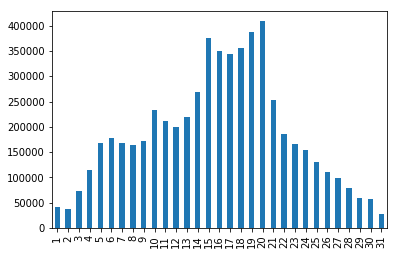

In [33]:
# the most popular day to pay
Day_group = Pay1.drop(['USER_ID'], axis =1)
Day_group.sum().plot.bar()

### Payment methods

In [43]:
Pay2 = Pay.drop(['PAY_DATE','SUMM'], axis =1) 

#Change name of method with code
label = LabelEncoder()
dicts = {}

label.fit(Pay2.NAME.drop_duplicates()) #make the list of vlues to encode
dicts['NAME'] = list(label.classes_)
Pay2.NAME = label.transform(Pay2.NAME) #replace name of the method with the code

#all of the methods in a str
Pay2 = Pay2.reset_index(level=['USER_ID'])
strJoin = lambda x:" ".join(x.astype(str))     
Pay2 = Pay2.groupby('USER_ID').agg({"NAME":strJoin})

Pay2 = Pay2.reset_index(level=['USER_ID'])
Pay2.head()

,USER_ID,NAME
0,143779,21 21 7 7 18 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7...
1,143780,7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
2,143789,21 21 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
3,143797,21 21 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 ...
4,143802,7 7 7 7 7 7 7 7


In [45]:
#methods
dicts

{'NAME': ['АВИЗО',
  'БАНК',
  'ВЗАИМОЗАЧЕТ /СПРАВКА/',
  'ГП, списанная по решению Общества (убытки)',
  'ГП, списанная по решению суда(убытки)',
  'ГП,возврат из бюджета',
  'ГП,подтвержденная судом',
  'ЕСПП /оплата/',
  'ИСС /on-line/',
  'КАРТЫ ОПЛАТЫ',
  'КАССА НАЛ. ФИЗ. ЛИЦА',
  'КВИТАНЦИЯ (реестр)',
  'Платежи Репэй_до выяснения',
  'Погашение ДЗ нереальной к взысканию',
  'Погашение ДЗ по причине НСДЗ',
  'Погашение ДЗ с истекш.сроком давности',
  'Погашение ДЗ,резервом по сомн.долгам',
  'СБЕРБАНК РФ /off_line/',
  'СБЕРБАНК РФ /on_line/',
  'Сбербанк_договор  КЦ_корректировка',
  'Списание ДЗ по договору цессии',
  'Телекомсервис-И /on_line/',
  'УФПС  /on_line/']}

In [49]:
Dict = pd.DataFrame(data=dicts)
Dict

,NAME
0,АВИЗО
1,БАНК
2,ВЗАИМОЗАЧЕТ /СПРАВКА/
3,"ГП, списанная по решению Общества (убытки)"
4,"ГП, списанная по решению суда(убытки)"
5,"ГП,возврат из бюджета"
6,"ГП,подтвержденная судом"
7,ЕСПП /оплата/
8,ИСС /on-line/
9,КАРТЫ ОПЛАТЫ


In [22]:
#str to a list for processing
num = Pay2['NAME'].size
dist=[]

for x in range(0,num):
    day_list = re.sub("[^0-9]"," ", Pay2.loc[x,'NAME'] ) 
    Pay2.set_value(x,'NAME',day_list.split())

#bag of words    
for x in range(0,num):
    vectorizer = CountVectorizer(Pay2.loc[x,'NAME'], token_pattern=r"\b\w+\b", vocabulary=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22'])
    dtm = vectorizer.fit_transform(Pay2.loc[x,'NAME'])  # a sparse matrix
    dtm.toarray()
    dist.append(dtm.sum( axis=0))
vocab = vectorizer.get_feature_names()  # a list

size = len(dist)
a = np.zeros(shape=(size,23))

for i in range(0,size):
    a[i] =dist[i]
        
n = pd.DataFrame(a,columns = vocab)                                                    
Pay2 = Pay2.join(n.astype(int))

Pay2 = Pay2.drop(['NAME'], axis =1) 

Pay2= Pay2.set_index(['USER_ID'])

Pay2 = Pay2.rename(columns = lambda x : 'M' + x)

Pay2.head()

,M0,M1,M2,M3,M4,M5,M6,M7,M8,M9,...,M13,M14,M15,M16,M17,M18,M19,M20,M21,M22
USER_ID,,,,,,,,,,,,,,,,,,,,,
143779,0,0,0,0,0,0,0,26,0,0,...,0,0,0,0,0,1,0,0,2,0
143780,0,0,0,0,0,0,0,19,0,0,...,0,0,0,0,0,0,0,0,0,0
143789,0,0,0,0,0,0,0,28,0,0,...,0,0,0,0,0,0,0,0,2,0
143797,0,0,0,0,0,0,0,28,0,0,...,0,0,0,0,0,0,0,0,2,0
143802,0,0,0,0,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
Pay2.to_csv('Pay_days2.csv',sep=';')

In [34]:
File = r'Pay_days2.csv'
Pay2 = pd.read_csv(File,  sep=';',encoding='cp1251')

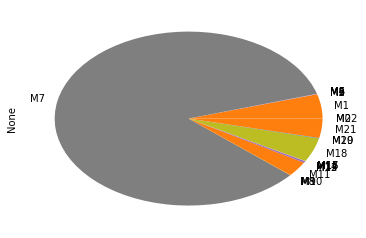

In [35]:
# the most popular day to pay
Method_group = Pay2.drop(['USER_ID'], axis =1)
Method_group.sum().plot.pie()

### Months

In [25]:
#Months and year to a ceparate column
Pay5 = Pay.reset_index(level=['USER_ID'])
datas = Pay['PAY_DATE'].dt.month
datas = datas.rename(columns={'PAY_DATE': 'MONTH'})
year = Pay['PAY_DATE'].dt.year
year = year.rename(columns={'PAY_DATE': 'YEAR'})

In [26]:
#Column "YearMonth"
Pay['MONTH']= datas
Pay['YEAR'] = year
Pay['MONTHS'] = Pay.YEAR.astype(str).str.cat(Pay.MONTH.astype(str).str.zfill(2) , sep='')
Pay5 = Pay.drop(['PAY_DATE', 'MONTH', 'YEAR', 'NAME'], axis =1) 

Pay5.head()

,SUMM,MONTHS
USER_ID,,
143779,670.0,201401
143779,652.0,201402
143779,1000.0,201404
143779,199.0,201406
143779,600.0,201407


In [27]:
#Table of payments by the months
Pay5 = Pay5.reset_index(level=['USER_ID'])
Pay5=Pay5.pivot_table('SUMM', index='MONTHS', columns='USER_ID')
Pay5

USER_ID,143779,143780,143789,143797,143802,143804,143809,143812,143815,143816,...,256796808314,256798589630,256799565701,256804442281,256809080312,256809573541,256812596597,256813907935,256814104815,256815928351
MONTHS,,,,,,,,,,,,,,,,,,,,,
201401,670.0,200.0,343.0,240.00,NaN,250.0,783.0,NaN,704.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201402,652.0,200.0,223.0,260.00,NaN,200.0,646.0,295.0,727.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201403,NaN,200.0,324.0,250.00,NaN,200.0,631.0,612.0,396.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201404,1000.0,200.0,276.0,250.00,1500.0,NaN,768.0,300.0,450.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201405,NaN,200.0,280.0,200.00,NaN,300.0,1147.0,300.0,545.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201406,199.0,NaN,340.0,NaN,NaN,600.0,746.0,300.0,759.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201407,600.0,200.0,230.0,243.00,500.0,NaN,600.0,300.0,542.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201408,48.0,250.0,207.0,75.00,NaN,NaN,568.0,300.0,396.0,238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201409,385.0,NaN,240.0,230.00,NaN,500.0,704.0,300.0,397.0,232.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# replace NaN values with 0 between first and last payments
L = Pay5.apply(pd.Series.last_valid_index)
L.astype(str)

F = Pay5.apply(pd.Series.first_valid_index)
F.astype(str)

for col in Pay5:
    First = Pay5.loc[ Pay5.index>=F[col], col]
    Last = First[ First.index<=L[col]].fillna(value=0)
    for i in Last.index:
        Pay5.set_value(i, col, Last[i])
Pay5.head()

USER_ID,143779,143780,143789,143797,143802,143804,143809,143812,143815,143816,...,256796808314,256798589630,256799565701,256804442281,256809080312,256809573541,256812596597,256813907935,256814104815,256815928351
MONTHS,,,,,,,,,,,,,,,,,,,,,
201401,670.0,200.0,343.0,240.0,NaN,250.0,783.0,NaN,704.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201402,652.0,200.0,223.0,260.0,NaN,200.0,646.0,295.0,727.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201403,0.0,200.0,324.0,250.0,NaN,200.0,631.0,612.0,396.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201404,1000.0,200.0,276.0,250.0,1500.0,0.0,768.0,300.0,450.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201405,0.0,200.0,280.0,200.0,0.0,300.0,1147.0,300.0,545.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
Pay5


USER_ID,143779,143780,143789,143797,143802,143804,143809,143812,143815,143816,...,256796808314,256798589630,256799565701,256804442281,256809080312,256809573541,256812596597,256813907935,256814104815,256815928351
MONTHS,,,,,,,,,,,,,,,,,,,,,
201401,670.0,200.0,343.0,240.00,NaN,250.0,783.0,NaN,704.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201402,652.0,200.0,223.0,260.00,NaN,200.0,646.0,295.0,727.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201403,0.0,200.0,324.0,250.00,NaN,200.0,631.0,612.0,396.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201404,1000.0,200.0,276.0,250.00,1500.0,0.0,768.0,300.0,450.0,1000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201405,0.0,200.0,280.0,200.00,0.0,300.0,1147.0,300.0,545.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201406,199.0,0.0,340.0,0.00,0.0,600.0,746.0,300.0,759.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201407,600.0,200.0,230.0,243.00,500.0,0.0,600.0,300.0,542.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201408,48.0,250.0,207.0,75.00,0.0,0.0,568.0,300.0,396.0,238.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
201409,385.0,0.0,240.0,230.00,0.0,500.0,704.0,300.0,397.0,232.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
Min = Pay5.min()
Max = Pay5.max()
Sum = Pay5.sum()
Med = Pay5.median()

Pay4 = pd.DataFrame()
Pay4['MIN'] = Min
Pay4['MAX'] = Max
Pay4['SUM'] = SumPay4.to_csv('Pay_days4.csv',sep=';')
Pay4['MED'] = Med
Pay4.head()

,MIN,MAX,SUM,MED
USER_ID,,,,
143779,0.0,1000.0,8963.80,199.0
143780,0.0,500.0,4341.00,200.0
143789,190.0,511.0,8065.00,257.0
143797,0.0,313.0,7158.38,243.0
143802,0.0,1500.0,5825.70,0.0


In [30]:
Pay4.to_csv('Pay_days4.csv',sep=';')

### Sums

In [20]:
Pay3 = Pay.drop(['NAME', 'PAY_DATE', 'MONTHS', 'MONTH' , 'YEAR'], axis =1)
Pay3 = Pay3.reset_index(level=['USER_ID'])

#SUm, min, max and median by every user
group = Pay3.groupby(['USER_ID'])
Pay3 = group.sum()
Pay3['MIN']= group.min()
Pay3['MAX']= group.max()
Pay3['MED']= group.median()

Pay3.head()

,SUMM,MIN,MAX,MED
USER_ID,,,,
143779,9343.80,48.0,1000.0,257.8
143780,4541.00,200.0,500.0,200.0
143789,8065.00,190.0,511.0,257.0
143797,7158.38,75.0,313.0,243.0
143802,5825.70,275.7,1500.0,600.0


In [21]:
Pay3.to_csv('Pay_days3.csv',sep=';')

### Combining all transformations

In [32]:
File1 = r'Pay_days1.csv'
File2 = r'Pay_days2.csv'
File3 = r'Pay_days3.csv'
File4 = r'Pay_days4.csv'
X1 = pd.read_csv(File1, sep=';', encoding='cp1251')
X2 = pd.read_csv(File2, sep=';', encoding='cp1251')
X4 = pd.read_csv(File4, sep=';', encoding='cp1251')

In [33]:
X1 = X1.set_index(['USER_ID'])
X2 = X2.set_index(['USER_ID'])
X4 = X4.set_index(['USER_ID'])

In [34]:
X = X1.join(X2)
X = X.join(X4)
X.head()

,1,2,3,4,5,6,7,8,9,10,...,M17,M18,M19,M20,M21,M22,MIN,MAX,SUM,MED
USER_ID,,,,,,,,,,,,,,,,,,,,,
143779,0,1,0,0,1,1,3,2,4,1,...,0,1,0,0,2,0,0.0,1000.0,8963.80,199.0
143780,2,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0.0,500.0,4341.00,200.0
143789,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,190.0,511.0,8065.00,257.0
143797,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,2,0,0.0,313.0,7158.38,243.0
143802,0,0,0,0,0,0,0,1,2,0,...,0,0,0,0,0,0,0.0,1500.0,5825.70,0.0


In [35]:
X.to_csv('Pay_days124.csv',sep=';')

### Answers table

In [36]:
Off2 = Off.drop(['PHONE', 'DATE_BEGIN', 'DATE_END','NAME'], axis =1)

# Pick Services we need by its code
serv = (203403, 81301, 203401, 2021, 80551, 203402, 40520, 81302, 81668)

num = Off2['COD'].size

for i in range(0,num):
    if Off2.loc[i,'COD'] in serv:
        Off2.set_value(i,'OFF', 1)
    else: Off2.set_value(i,'OFF', 0)
        
Off2 = Off2.groupby('USER_ID').max()

Off2 = Off2.drop(['COD'], axis =1)

Off2['OFF'] = Off2.OFF.astype(int)

Off2

,OFF
USER_ID,
143779,0
143780,1
143789,0
143797,0
143802,1
143804,1
143809,1
143812,1
143815,0


In [37]:
Off2.to_csv('Off_Y.csv',sep=';')

### Tables verification

In [50]:
File1 = r'Off_Y.csv'
File2 = r'Pay_days124.csv'

In [51]:
y = pd.read_csv(File1, sep=';', encoding='cp1251')
y.head()

,USER_ID,OFF
0,143779,0
1,143780,1
2,143789,0
3,143797,0
4,143802,1


In [52]:
X = pd.read_csv(File2, sep=';', encoding='cp1251')
X.head()

,USER_ID,1,2,3,4,5,6,7,8,9,...,M17,M18,M19,M20,M21,M22,MIN,MAX,SUM,MED
0,143779,0,1,0,0,1,1,3,2,4,...,0,1,0,0,2,0,0.0,1000.0,8963.80,199.0
1,143780,2,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0.0,500.0,4341.00,200.0
2,143789,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,190.0,511.0,8065.00,257.0
3,143797,0,0,0,0,0,0,0,0,1,...,0,0,0,0,2,0,0.0,313.0,7158.38,243.0
4,143802,0,0,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0.0,1500.0,5825.70,0.0


In [53]:
# Delete rows with extra ID
y = y.loc[y['USER_ID'].isin(X['USER_ID'])]
X = X.loc[X['USER_ID'].isin(y['USER_ID'])] 

In [54]:
y = y.sort_values(by='USER_ID')
X = X.sort_values(by='USER_ID')

In [55]:
y = y.drop(['USER_ID'], axis =1)
X = X.drop(['USER_ID'], axis =1)

In [56]:
# Delete columns that affect negatively on the prediction
X = X.drop(['SUM','MED','MAX', 'M13', 'M14', 'M15', 'M16', 'M11', 'M1', 'M3'], axis=1)

### Logistic Regression

In [57]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.3)

In [58]:
y_train = y_train['OFF'].ravel()
scaler = StandardScaler()

x_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),)
x_test_scaled = pd.DataFrame(scaler.fit_transform(X_test),)

In [59]:
cv = KFold(n=len(y_train), n_folds=5, shuffle=True, random_state=42)

param_grid = { 'C': [1e-5, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 1, 10] }

clf = LogisticRegression(penalty='l2', random_state=42)

gs = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=cv, verbose=2, n_jobs=-1)

gs.fit(x_train_scaled, y_train)

print('Наилучшее качество:', gs.best_score_)

gs.grid_scores_

gs.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.8min finished


Наилучшее качество: 0.6215499030725136


LogisticRegression(C=0.005, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
# coefficients weight
weight= sorted(dict(zip(X_train.columns, gs.best_estimator_.coef_[0])).items(), key=lambda x: -abs(x[1]))
Coef_weight = pd.DataFrame(data = weight, columns=['Feature', 'Weight'])
Coef_weight = Coef_weight.set_index(['Feature'])
Coef_weight

,Weight
Feature,
M7,0.343489
M20,0.085243
M21,0.080901
M6,0.076498
M18,0.073330
M17,-0.062494
M2,-0.056776
23,0.050725
24,0.048196


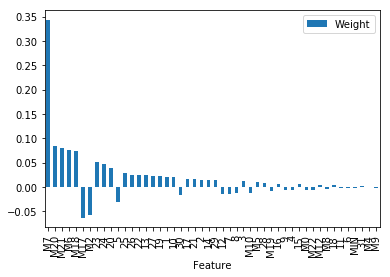

In [71]:
Coef_weight.plot.bar()


### Decision trees

In [60]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)
clf_dt.fit (x_train_scaled, y_train)
clf_dt.score (x_test_scaled, y_test)

0.70043068873175129

### Gradient Boosting Classifier

In [61]:
gbc = GradientBoostingClassifier(n_estimators=150, max_depth=4, loss='deviance')
gbc.fit(x_train_scaled, y_train)
gbc.score(x_test_scaled, y_test)

0.71008107807930099

### Random Forest Classifier

In [62]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=4, criterion='entropy')
rfc.fit(x_train_scaled, y_train)
rfc.score(x_test_scaled, y_test)                      

0.69492675823429961

TEST

In [33]:
user = Off['USER_ID']< 143816
User = Off[user]
User

,USER_ID,PHONE,DATE_BEGIN,DATE_END,COD,NAME
0,143779,NaN,01.03.1997,21.07.2015,20155,ПВ Пользование абонентской радиоточкой
1,143779,NaN,01.10.2014,15.07.2015,1470,ГТС Тональный набор
2,143779,NaN,01.10.2014,15.07.2015,1469,ГТС Уведомление о поступлении нового вызова
3,143780,3842524316,01.10.2013,21.01.2016,203403,ГТС Пред.в пост.польз.абон.линии с инд.схемой ...
4,143780,NaN,01.10.2014,21.01.2016,1469,ГТС Уведомление о поступлении нового вызова
5,143780,NaN,01.10.2014,21.01.2016,1470,ГТС Тональный набор
6,143780,NaN,30.12.2010,22.01.2016,53105,*Получение счета/расшифровок Абонентом в подра...
7,143789,NaN,01.07.2013,27.01.2016,210010,*Клиент пульта охраны
8,143797,NaN,01.10.2014,12.02.2015,1469,ГТС Уведомление о поступлении нового вызова
9,143802,NaN,01.10.2014,09.03.2016,1470,ГТС Тональный набор


In [34]:
User = User.drop(['PHONE', 'DATE_BEGIN', 'DATE_END','NAME'], axis =1)

In [22]:
User.head()

,USER_ID,COD
0,143779,20155
1,143779,1470
2,143779,1469
3,143780,203403
4,143780,1469


In [35]:
serv = (203403, 81301, 203401, 2021, 80551, 203402, 40520, 81302, 81668)
serv

(203403, 81301, 203401, 2021, 80551, 203402, 40520, 81302, 81668)

In [36]:
num = User['COD'].size

for i in range(0,num):
    if User.loc[i,'COD'] in serv:
        User.set_value(i,'OFF', 1)
    else: User.set_value(i,'OFF', 0)

User

,USER_ID,COD,OFF
0,143779,20155,0.0
1,143779,1470,0.0
2,143779,1469,0.0
3,143780,203403,1.0
4,143780,1469,0.0
5,143780,1470,0.0
6,143780,53105,0.0
7,143789,210010,0.0
8,143797,1469,0.0
9,143802,1470,0.0


In [37]:
User = User.groupby('USER_ID').max()

In [39]:
User = User.drop(['COD'], axis =1)

In [45]:
User['OFF'] = User.OFF.astype(int)


In [46]:
User

,OFF
USER_ID,
143779,0
143780,1
143789,0
143797,0
143802,1
143804,1
143809,1
143812,1
143815,0
